<a href="https://colab.research.google.com/github/Ryandry1st/Machine-Learning/blob/master/convnets_with_small_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Using convnets with small datasets

Jay Urbain, PhD

This notebook was created from the code found in Chapter 5, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff), by Francios Challet.

#### Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation. Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. 

We will classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). 2000 
pictures will be used for training, 1000 for validation, and 1000 for testing.

We will start with a basic strategy to tackle this problem: training a new model from scratch on what little data we have. We will start by naively training a small convnet on our 2000 training samples, without any regularization to set a baseline for what can be achieved. This will get us to a classification accuracy of ~71%. At that point, our main issue will be overfitting. 

Then we will introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve our network to reach an accuracy of ~82%.

We will then review two more essential techniques for applying deep learning to small datasets: *doing feature extraction with a pre-trained network* (this will get us to an accuracy of 90% - 93%), and *fine-tuning a pre-trained network* (this will get us to 
our final accuracy of ~95%). 

Together, these three strategies -- training a small model from scratch, doing feature extracting using a pre-trained model, and fine-tuning a pre-trained model will constitute your future toolbox for tackling the problem of doing computer vision with small datasets.

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

tf.test.gpu_device_name()

1.13.0-rc0
2.2.4-tf


'/device:GPU:0'

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental 
characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual 
feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where 
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for 
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can 
potentially suffice if the model is small and well-regularized and if the task is simple. 
Because convnets learn local, translation-invariant features, they are very 
data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results 
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model 
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of 
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used 
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: 
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

Alternatively, you can download everything from my Google Drive. This will also facilitate running this notebook in Google Collab  on Google's compute platform. This option seems like a no brainer. The data on Google Drive has already been prepared.

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our 
models on less than 10% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading 
and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation 
set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

In [0]:
import os, shutil
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ryandry1st","key":"2e751ea71a12afd6a0868cd82a2d0fcb"}'}

Optionally mount Google Drive

In [0]:
!pip install -q kaggle
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls 'drive/My Drive/Colab Notebooks/cats_and_dogs_small/train'
import json
token = {"username":"ryandry1st","key":"2e751ea71a12afd6a0868cd82a2d0fcb"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!ls

cats  dogs


FileNotFoundError: ignored

In [0]:
#!kaggle competitions download -c dogs-vs-cats -p 'drive/My Drive/Colab Notebooks/cats_and_dogs_small/'

In [0]:
#import zipfile
#with zipfile.ZipFile("drive/My Drive/Colab Notebooks/cats_and_dogs_small/train/train.zip","r") as zip_ref:
#    zip_ref.extractall("drive/My Drive/Colab Notebooks/cats_and_dogs_small/train")

If you've downloaded the data from Kaggle, verify you have the proper path to the data.

In [0]:
!ls /Users/jayurbain/Dropbox/machine-learning/machine-learning/data/dogs-vs-cats
#!ls '/content/drive/My Drive/machine-learning-data/cats_and_dogs_small/train/cats'

ls: cannot access '/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/dogs-vs-cats': No such file or directory


**Optionally modify the base_dir below to Google Drive.**

In [0]:
# The path to the directory where the original
# dataset was uncompressed
import os
original_dataset_dir = '/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/dogs-vs-cats/train'
#original_dataset_dir = '/content/drive/My Drive/machine-learning-data/dogs-vs-cats/train'

# The directory where we will
# store our smaller dataset
base_dir = 'drive/My Drive/Colab Notebooks/cats_and_dogs_small'
#base_dir = '/content/drive/My Drive/machine-learning-data/cats_and_dogs_small'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

In [0]:
train_dir

'drive/My Drive/Colab Notebooks/cats_and_dogs_small/train'

In [0]:
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

In [0]:
train_dir = train_dir + "/train"
# Copy first 1000 cat images to train_cats_dir 
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)] 
for fname in fnames:
    src = os.path.join(train_dir, fname) 
    dst = os.path.join(train_cats_dir, fname) 
    shutil.copyfile(src, dst) 
    
# Copy next 500 cat images to validation_cats_dir 
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(train_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst) 
    
# Copy next 500 cat images to test_cats_dir 
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)] 
for fname in fnames:
    src = os.path.join(train_dir, fname) 
    dst = os.path.join(test_cats_dir, fname) 
    shutil.copyfile(src, dst) 
    
# Copy first 1000 dog images to train_dogs_dir 
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(train_dir, fname) 
    dst = os.path.join(train_dogs_dir, fname) 
    shutil.copyfile(src, dst) 
    
# Copy next 500 dog images to validation_dogs_dir 
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(train_dir, fname) 
    dst = os.path.join(validation_dogs_dir, fname) 
    shutil.copyfile(src, dst) 
    
# Copy next 500 dog images to test_dogs_dir 
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(train_dir, fname) 
    dst = os.path.join(test_dogs_dir, fname) 
    shutil.copyfile(src, dst)

NameError: ignored

Execute the following cell only if you need to set up the data on your local drive.

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [0]:
train_dogs_dir

'drive/My Drive/Colab Notebooks/cats_and_dogs_small/train/dogs'

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [0]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


In [0]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training dog images: 1000


In [0]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

total validation cat images: 500


In [0]:
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total validation dog images: 500


In [0]:
print('total test cat images:', len(os.listdir(test_cats_dir)))

total test cat images: 500


In [0]:
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total test dog images: 500


We have 2000 training images, 1000 validation images and 1000 test images. In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

## Building our network

You should be familiar with buildiong a small convnet for MNIST using Keras. If not, complete the MNIST notebook. We will use the same general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

Since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network and to further reduce the size of the feature maps, so that they aren't overly large when we reach the `Flatten` layer. Since we start from inputs of size 150x150, we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a `sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

For our compilation step, we'll go with the `RMSprop` optimizer. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss.

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows you to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = 'drive/My Drive/Colab Notebooks/cats_and_dogs_small/train/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

First, set up a TensorBoard call back for model visualization.

In [0]:
tensor_board = keras.callbacks.TensorBoard(log_dir='Graph', histogram_freq=0,  
          write_graph=True, write_images=True)

tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[tensor_board])

Epoch 1/30
100/100 [==============================] - 497s 5s/step - loss: 0.6835 - acc: 0.5670 - val_loss: 0.6699 - val_acc: 0.6160
Epoch 2/30
100/100 [==============================] - 13s 135ms/step - loss: 0.6545 - acc: 0.6135 - val_loss: 0.6388 - val_acc: 0.6310
Epoch 3/30
100/100 [==============================] - 13s 135ms/step - loss: 0.6098 - acc: 0.6725 - val_loss: 0.6358 - val_acc: 0.6350
Epoch 4/30
100/100 [==============================] - 13s 133ms/step - loss: 0.5677 - acc: 0.7145 - val_loss: 0.5849 - val_acc: 0.6850
Epoch 5/30
100/100 [==============================] - 13s 134ms/step - loss: 0.5329 - acc: 0.7250 - val_loss: 0.5974 - val_acc: 0.6630
Epoch 6/30
100/100 [==============================] - 14s 135ms/step - loss: 0.5122 - acc: 0.7550 - val_loss: 0.6133 - val_acc: 0.6560
Epoch 7/30
100/100 [==============================] - 14s 136ms/step - loss: 0.4814 - acc: 0.7700 - val_loss: 0.5964 - val_acc: 0.6870
Epoch 8/30
100/100 [==============================] - 14s

It is good practice to always save your models after training:

In [0]:
model.save('cats_and_dogs_small_1.h5')

Plot the loss and accuracy of the model over the training and validation data during training:

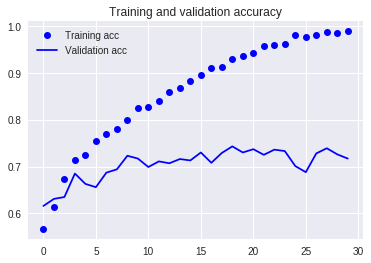

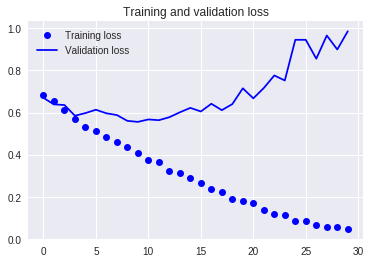

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to 
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data 
augmentation*.

To visualize your model in tensorboard. Run the following from your command line.  
    
$ tensorboard --logdir ./Graph

Open your web browser and enter the address below:

htttp://localhost:6006

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. Let's get started with an example:

In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Additional references:  
https://keras.io/preprocessing/image/  
https://machinelearningmastery.com/image-augmentation-deep-learning-keras/   

Let's take a look at our augmented images:

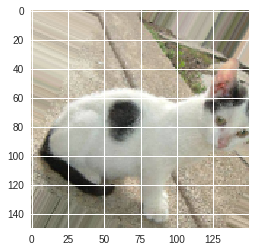

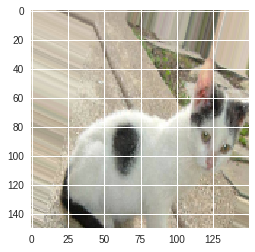

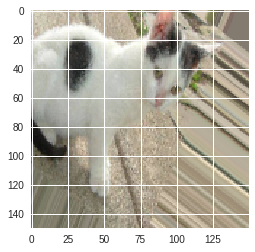

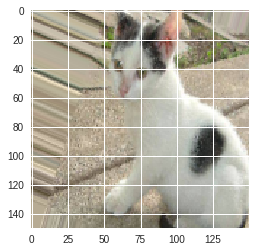

In [0]:
# This is module with image preprocessing utilities
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see the same input twice. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images. We cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [0]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy',
 #             optimizer=optimizers.adam(lr=1e-4),
  #            metrics=['acc'])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
___________________________

In [0]:
tensor_board2 = keras.callbacks.TensorBoard(log_dir='Graph2', histogram_freq=0,  
          write_graph=True, write_images=True)

Let's train our network using data augmentation and dropout:

In [0]:
# with tf.Session() as sess:
#      sess.run(tf.global_variables_initializer())

# keras.set_session(tf.Session(graph=model.output.graph)) init 
#     = keras.tf.global_variables_initializer() K.get_session().run(init)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[tensor_board])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 37s 374ms/step - loss: 0.6931 - acc: 0.5241 - val_loss: 0.6848 - val_acc: 0.5863
Epoch 2/100
100/100 [==============================] - 35s 346ms/step - loss: 0.6799 - acc: 0.5628 - val_loss: 0.6637 - val_acc: 0.5747
Epoch 3/100
100/100 [==============================] - 36s 361ms/step - loss: 0.6641 - acc: 0.5962 - val_loss: 0.6331 - val_acc: 0.6212
Epoch 4/100
100/100 [==============================] - 34s 338ms/step - loss: 0.6286 - acc: 0.6369 - val_loss: 0.6040 - val_acc: 0.6566
Epoch 5/100
100/100 [==============================] - 34s 335ms/step - loss: 0.6139 - acc: 0.6584 - val_loss: 0.5901 - val_acc: 0.6878
Epoch 6/100
100/100 [==============================] - 34s 336ms/step - loss: 0.5968 - acc: 0.6816 - val_loss: 0.5531 - val_acc: 0.7043
Epoch 7/100
100/100 [==============================] - 34s 337ms/step - loss: 0.5736 - acc: 0.7012 -

Let's save our model -- we will be using it in the section on convnet visualization.

In [0]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

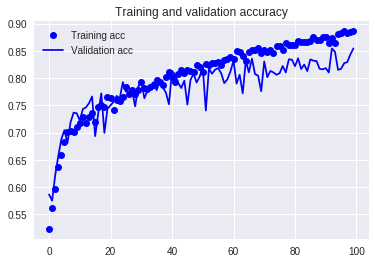

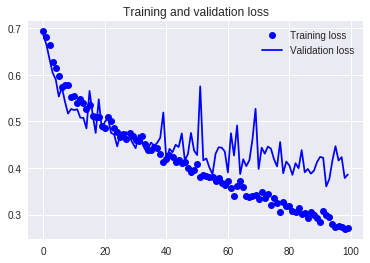

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation 
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution 
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove 
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a 
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two 
sections.

To visualize your model in tensorboard. Run the following from your command line.  
    
$ tensorboard --logdir ./Graph2

Open your web browser and enter the address below:

htttp://localhost:6006

**Questions:**  

1) In the first model we created without regularization and data augmentation at what point in the training process, i.e., number of epochs did the model start to overfit?  
2) How do you configure ImageDataGenerator to generate images that are a mirror reflection about the y-axis?   
3) Briefly, explain the dropout procedure used in the second augmented image model above.  
4) Instrument your last model's fit method to return the Keras training history. Use the history to generate a plot of training versus validation (test) loss.  
5) Experiment with a minimum of 3 modifications to the last model and try to improve test accuracy performance. Modifications could include reducing dropout, increasing the number of layers, trying other regularization methods, trying other optimization functions, e.g., adam.
4) Generate training versus validation loss plots.   
2) Generate a Tensorboard plot for your final model. 






**1) The model started to overfit around epoch number 4, where the valdiation accuracy only mildly increased, while the training accuracy went up by more than 4% each epoch. A good idea of overfitting is when the training accuracy is improving by much more than the validation set.**

**2) ImageDataGenerator can be configured to produce mirror reflections by horizontal_flip optional parameter.**

**3) Dropout is the method of having a certain probability of "forgetting" about some information. If this occurs, then the value is lost. This helps the overall network to not overfit, because features are lost. It also forces the network to optimize for robust features, rather than feature which are noisy. **

**4) See the provided code above? This is already being done with the history and plotting code.**

**5) Tested modifications include adam optimizer, reducing the dropout, changing the activation to a softmax cross entropy, and transfer learning. **



Epoch 1/100
100/100 [==============================] - 37s 368ms/step - loss: 0.6931 - acc: 0.5181 - val_loss: 0.6819 - val_acc: 0.5102
Epoch 2/100
100/100 [==============================] - 35s 346ms/step - loss: 0.6806 - acc: 0.5709 - val_loss: 0.6981 - val_acc: 0.5052
Epoch 3/100
100/100 [==============================] - 34s 336ms/step - loss: 0.6619 - acc: 0.6066 - val_loss: 0.6632 - val_acc: 0.5888
Epoch 4/100
100/100 [==============================] - 33s 325ms/step - loss: 0.6387 - acc: 0.6325 - val_loss: 0.6322 - val_acc: 0.6224
Epoch 5/100
100/100 [==============================] - 33s 327ms/step - loss: 0.6189 - acc: 0.6469 - val_loss: 0.7443 - val_acc: 0.5522
Epoch 6/100
100/100 [==============================] - 33s 329ms/step - loss: 0.6129 - acc: 0.6681 - val_loss: 0.6055 - val_acc: 0.6561
Epoch 7/100
100/100 [==============================] - 32s 324ms/step - loss: 0.5849 - acc: 0.6850 - val_loss: 0.5834 - val_acc: 0.6888
Epoch 8/100
100/100 [===========================

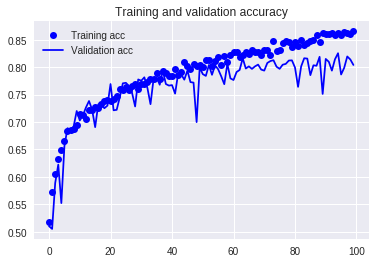

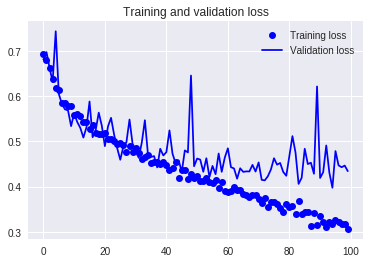

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

tensor_board2 = keras.callbacks.TensorBoard(log_dir='Dropout', histogram_freq=0,  
          write_graph=True, write_images=True)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[tensor_board])

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


So reducing the dropout did not help, in fact the model seems to be performing about 5% worse on the validation set than the higher valued dropout and adam optimizer from before.


Epoch 1/100
100/100 [==============================] - 38s 380ms/step - loss: 0.6912 - acc: 0.5375 - val_loss: 0.6710 - val_acc: 0.5952
Epoch 2/100
100/100 [==============================] - 33s 335ms/step - loss: 0.6766 - acc: 0.5784 - val_loss: 0.6764 - val_acc: 0.5419
Epoch 3/100
100/100 [==============================] - 32s 322ms/step - loss: 0.6586 - acc: 0.6056 - val_loss: 0.6308 - val_acc: 0.6313
Epoch 4/100
100/100 [==============================] - 32s 322ms/step - loss: 0.6401 - acc: 0.6281 - val_loss: 0.5993 - val_acc: 0.6746
Epoch 5/100
100/100 [==============================] - 33s 326ms/step - loss: 0.6222 - acc: 0.6509 - val_loss: 0.5809 - val_acc: 0.6796
Epoch 6/100
100/100 [==============================] - 32s 322ms/step - loss: 0.6091 - acc: 0.6616 - val_loss: 0.5795 - val_acc: 0.6920
Epoch 7/100
100/100 [==============================] - 32s 319ms/step - loss: 0.5925 - acc: 0.6831 - val_loss: 0.6253 - val_acc: 0.6276
Epoch 8/100
100/100 [===========================

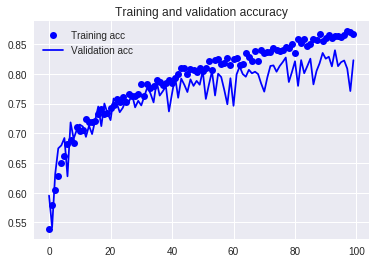

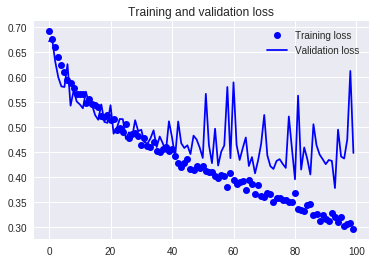

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

tensor_board2 = keras.callbacks.TensorBoard(log_dir='Softmax', histogram_freq=0,  
          write_graph=True, write_images=True)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[tensor_board])

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

So we see that changing to 2 nodes and a softmax activation produces slightly better results than the dropout lowered option, but not better than the Adam optimizer option.

In [0]:
from keras import applications
from keras.models import Sequential, Model
from keras import backend as k 

model = applications.inception_resnet_v2.InceptionResNetV2(weights = "imagenet", include_top=False, input_shape = (150, 150, 3))

# freeze imagenet layers to avoid training base elements. Only train classification layer
for layer in model.layers:
    layer.trainable = False
    
x = model.output
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
predictions = layers.Dense(1, activation="sigmoid")(x)


full_model = Model(input = model.input, output = predictions)

full_model.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(lr=0.00001), metrics=["accuracy"])

#full_model.summary() # this is really long so don't call it unless you are interested in seeing the model shape

tensor_board2 = keras.callbacks.TensorBoard(log_dir='TransferGraph', histogram_freq=0,  
          write_graph=True, write_images=True)

history = full_model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[tensor_board])

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


219062272/219055592 [==============================] - 3s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/100
100/100 [==============================] - 52s 519ms/step - loss: 0.6135 - acc: 0.6353 - val_loss: 0.0989 - val_acc: 0.9646
Epoch 2/100
100/100 [==============================] - 40s 399ms/step - loss: 0.4961 - acc: 0.7422 - val_loss: 0.0873 - val_acc: 0.9734
Epoch 3/100
100/100 [==============================] - 40s 397ms/step - loss: 0.4555 - acc: 0.7609 - val_loss: 0.0992 - val_acc: 0.9691
Epoch 4/100
100/100 [==============================] - 42s 416ms/step - loss: 0.4171 - acc: 0.7891 - val_loss: 0.1052 - val_acc: 0.9740
Epoch 5/100
100/100 [==============================] - 40s 396ms/step - loss: 0.4165 - acc: 0.7894 - val_loss: 0.1108 - val_acc: 0.9768
Epoch 6/100
100/100 [==============================] - 40s 396ms/step - loss: 0.3830 - acc: 0.8219 - val_loss: 0.1000 - val_acc: 0.9797
Epoch 7/100
100/100 [==============================] - 40s 396ms/step - loss: 0.3732 - acc: 0.8219 - val_loss: 0.1067 - val_acc: 0.9807
Epoch 8/100
100/100 [===========================

In [0]:
from keras import applications
from keras.models import Sequential, Model
from keras import backend as k 

model = applications.inception_resnet_v2.InceptionResNetV2(weights = "imagenet", include_top=False, input_shape = (150, 150, 3))

# freeze imagenet layer

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

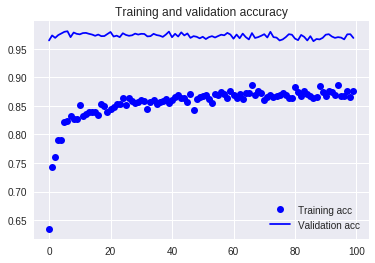

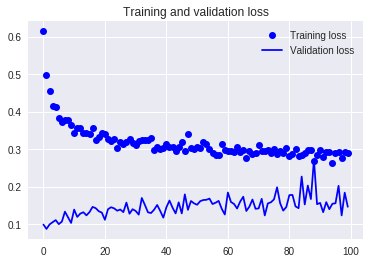

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The pretrained, transfer learning model is <font size=5> **very** </font>effective even without any training. It is interesting to note that it performs much better on the validation set than on the training set. I believe this is because it probably was trained on non-augmented photos of dogs and cats or that it did not experience the variation that this augmentation is doing, so the training set is more difficult than the validation set, which is not augmented. The model still performs incredibly well for very little effort on my end, which is always an exciting feeling even if it is really just taking someone else's work. 